In [1]:
import numpy as np #numerical computing
import pandas as pd # data manupulation and handling structured data like dataframes

# data visualization
import matplotlib.pyplot as plt #making plots
import seaborn as sns # creating attractive and informative statistical graphics and visualizing complex datasets and performing exploratory data analysis
import plotly.io as pio # makes interactive, publication-quality graphs online
# visualization settings
#plt.style.use('seaborn') # default plotting style
plt.rcParams['figure.facecolor'] = 'white' # sets the background color of all figures (plots) to white by modifying the rcParams dictionary
pio.renderers.default = 'colab' #  sets the default renderer for Plotly visualizations to colab

# prophet
from prophet.diagnostics import cross_validation, performance_metrics # assess the predictive performance of the model by splitting data into training and test sets and performance metrics is used to calculate various performance metrics, such as Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE), based on the cross-validation results
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
#plot_plotly: Creates an interactive forecast plot using Plotly.
#plot_components_plotly: Plots the components of the forecast (trend, seasonality, holidays) using Plotly.
#plot_cross_validation_metric: Plots the cross-validation metrics over the forecast horizon.
from prophet import Prophet

# evaluation metric
from sklearn.metrics import mean_squared_log_error
#regression loss metric that is useful for evaluating models where the prediction error should be penalized more for underestimation than overestimation, especially when dealing with exponential growth data.

# others
import itertools # creating iterators
from tqdm import tqdm #progress bar for loops

In [2]:
import sys
if('google.colab' in sys.modules):
    from google.colab import drive
    drive.mount('/content/drive', force_remount = True)
    DIR = '/content/drive/MyDrive/Colab Notebooks/OddSemester2024/ProphetSalesForecasting'
    DATA_DIR = DIR+'/Data/'
else:
    DATA_DIR = 'Data/'

Mounted at /content/drive


In [3]:
FILE = DATA_DIR + 'Sales_.csv'
sale = pd.read_csv(FILE)
print(sale.head(5))
sale.info()

    sale_date  product_unit_sales  discount_amount (Rs.)  mrp_amount (Rs.)  \
0  30-07-2016                1469              841262.54         2772121.0   
1  24-12-2016                2668              951832.49         5265812.0   
2  05-09-2016                 595               20077.38         1112225.0   
3  08-09-2016                 655              127786.36         1238535.0   
4  17-07-2016                2561             1385088.70         4822249.0   

  product  
0   shirt  
1   shirt  
2   shirt  
3   shirt  
4   shirt  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3112 entries, 0 to 3111
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sale_date              3112 non-null   object 
 1   product_unit_sales     3112 non-null   int64  
 2   discount_amount (Rs.)  3112 non-null   float64
 3   mrp_amount (Rs.)       3112 non-null   float64
 4   product                3112 non-null

In [4]:
sale['sale_date'] = pd.to_datetime(sale['sale_date'], dayfirst=True)
sale.sort_values('sale_date', inplace=True)
sale['total_revenue'] = sale['mrp_amount (Rs.)']-sale['discount_amount (Rs.)']
sale.head(5)
sale.dtypes

,0
sale_date,datetime64[ns]
product_unit_sales,int64
discount_amount (Rs.),float64
mrp_amount (Rs.),float64
product,object
total_revenue,float64


In [5]:
sale['sale_date'].apply(['min', 'max'])#date range of sales data

,sale_date
min,2016-01-01
max,2024-08-19


In [6]:
#count of how many shirts were sold yearly
yearly_sales = sale.groupby(sale['sale_date'].dt.year)['product_unit_sales'].sum()
yearly_sales

,product_unit_sales
sale_date,
2016,336955
2017,310557
2018,319559
2019,277193
2020,147819
2021,188996
2022,250505
2023,230842
2024,125472


In [7]:
top_5_years = sale['sale_date'].dt.year.value_counts().head(5)
top_5_years

,count
sale_date,
2016,366
2017,365
2018,365
2019,365
2021,365


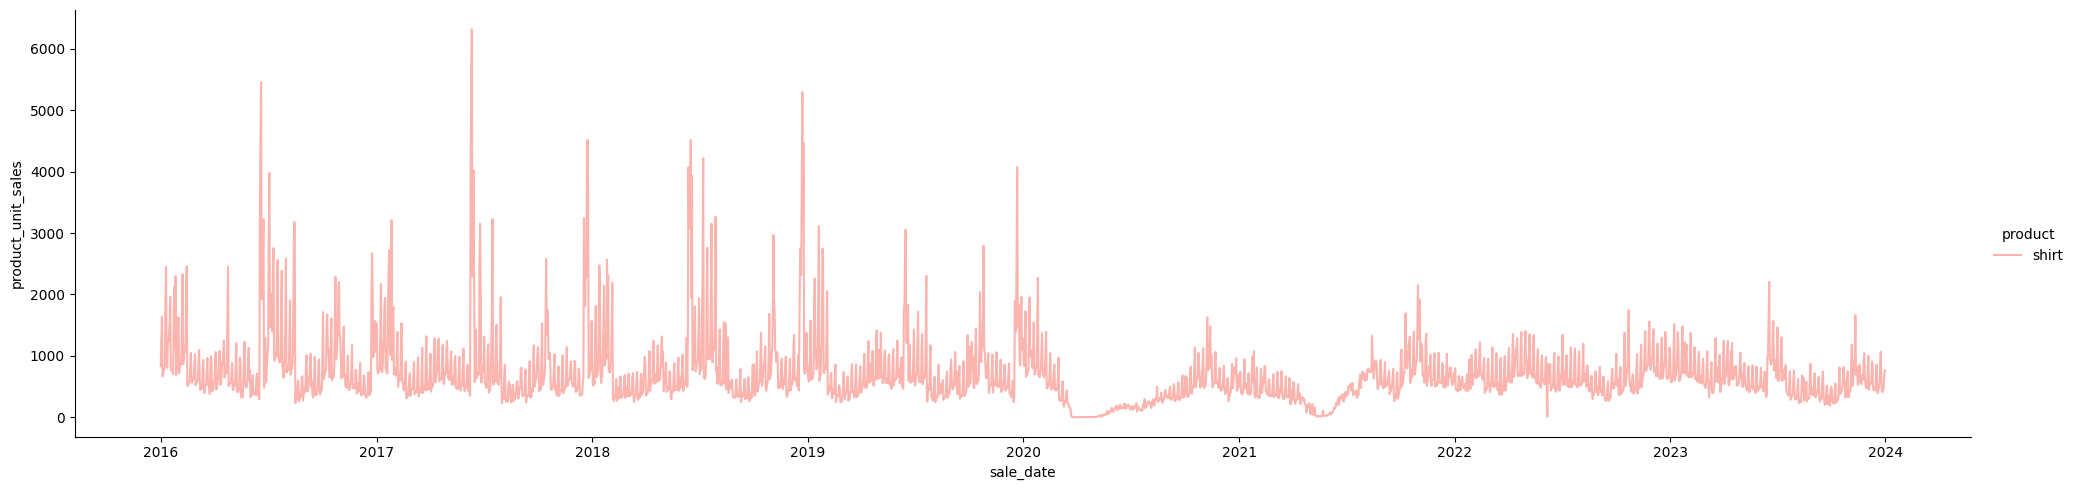

In [8]:
#plot a graph for eight year of sales

import matplotlib.pyplot as plt
eight_years = sale['sale_date'].dt.year.value_counts().head(8)
sales_eight_years_data = sale[sale['sale_date'].dt.year.isin(eight_years.index)]
sns.relplot(data=sales_eight_years_data,
            kind='line',
            x='sale_date',
            y='product_unit_sales',
            palette='Pastel1',
            hue = 'product',
            aspect=20/5)
plt.show()



In [9]:
# Group by year and sum the product unit sales
yearly_sales = sale.groupby(sale['sale_date'].dt.year)['product_unit_sales'].sum()

yearlysale = yearly_sales.reset_index()# Reset the index to convert Series to DataFrame

# Rename the columns
yearlysale = yearlysale.rename(columns={'sale_date': 'ds', 'product_unit_sales': 'y'})

# Display the first few rows
yearlysale.head(9)


,ds,y
0,2016,336955
1,2017,310557
2,2018,319559
3,2019,277193
4,2020,147819
5,2021,188996
6,2022,250505
7,2023,230842
8,2024,125472


In [10]:
min,max = (sale['sale_date'].apply(['min', 'max']))
min,max

(Timestamp('2016-01-01 00:00:00'), Timestamp('2024-08-19 00:00:00'))

In [11]:
#fitting a time series model is to extract the pattern information of a time series in order to perform a forecasting over the specified period of time.
model_31 = Prophet()
model_31.fit(yearlysale)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 6.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_q6q146s/a085jk4q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_q6q146s/s05u9qq4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75824', 'data', 'file=/tmp/tmp_q6q146s/a085jk4q.json', 'init=/tmp/tmp_q6q146s/s05u9qq4.json', 'output', 'file=/tmp/tmp_q6q146s/prophet_model6mjl425e/prophet_model-20250122095839.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:58:39 - cmdstanpy - INFO - Chain [1] start processing
IN

In [12]:
sale['sale_date'] = pd.to_datetime(sale['sale_date'], dayfirst=True)

# Rename columns for Prophet
sale = sale.rename(columns={'sale_date': 'ds', 'product_unit_sales': 'y'})
model_31 = Prophet()

# Fit the model with your historical data
model_31.fit(sale)
future_32 = model_31.make_future_dataframe(periods=6, freq='M')
forecast_32 = model_31.predict(future_32)

# Display the predictions for the next 6 months
forecast_next_6_months = forecast_32[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)
print(forecast_next_6_months)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_q6q146s/l7l2r61o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_q6q146s/1g16humb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3444', 'data', 'file=/tmp/tmp_q6q146s/l7l2r61o.json', 'init=/tmp/tmp_q6q146s/1g16humb.json', 'output', 'file=/tmp/tmp_q6q146s/prophet_modeled6dflw6/prophet_model-20250122095842.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:58:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:58:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning:

'M' is deprecated and will be removed in a future version, 

             ds        yhat  yhat_lower   yhat_upper
3112 2024-08-31  557.191889   33.962750  1091.733527
3113 2024-09-30  215.185219 -326.626251   739.112610
3114 2024-10-31  507.808288  -13.201159  1049.257287
3115 2024-11-30  557.092699    0.563802  1087.311437
3116 2024-12-31  593.616731   62.183734  1150.923614
3117 2025-01-31  591.615731   60.407997  1119.632562


In [13]:
forecast_result =forecast_32['yhat']# Extract the forecasted values (yhat) from the forecast DataFrame
forecast_add_components =forecast_32['trend'] + forecast_32['weekly'] + forecast_32['yearly']# Compute the sum of the trend, weekly, and yearly components
 # Check if the forecasted values match the sum of components
# Rounding is applied to avoid issues with floating-point precision
# This comparison checks if all the rounded forecasted values are equal to the rounded sum of components
(forecast_result.round(10) == forecast_add_components.round(10)).all()

True

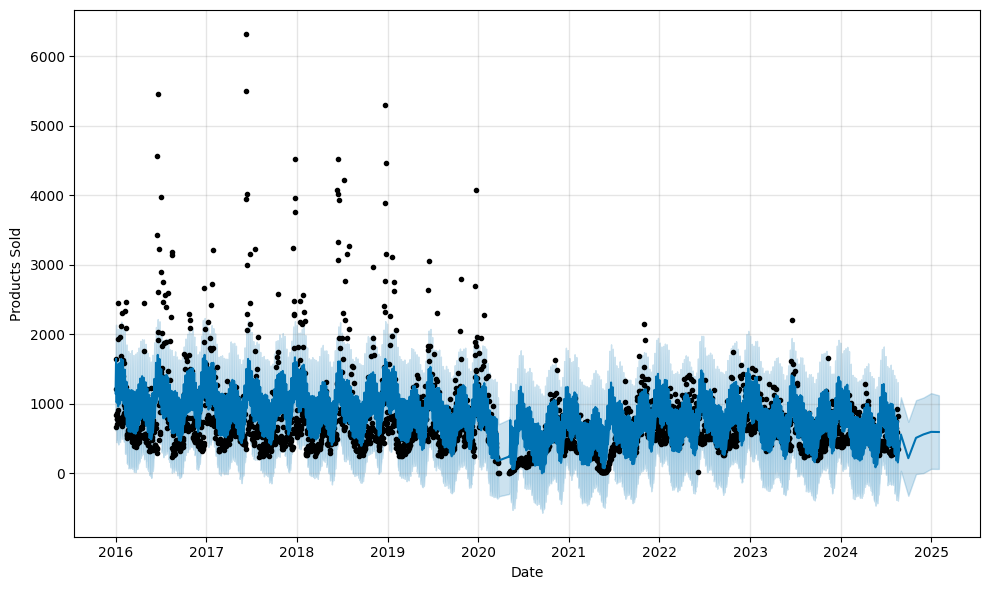

In [14]:
fig = model_31.plot(forecast_32, xlabel='Date', ylabel='Products Sold')# Plot the forecast results

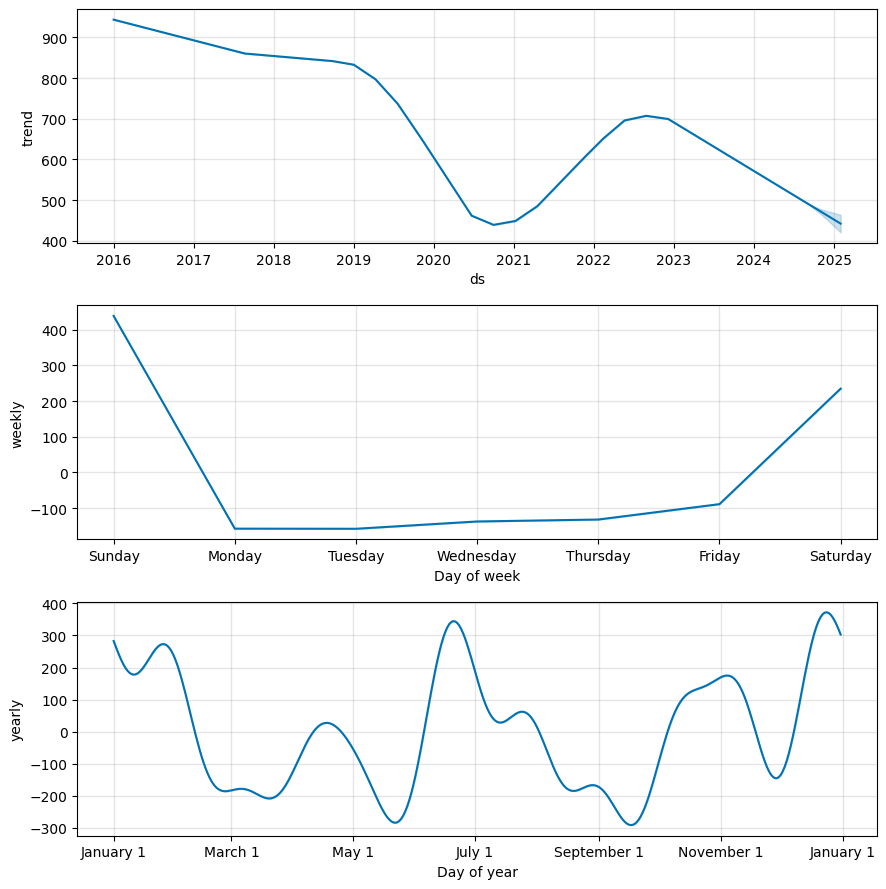

In [15]:
fig = model_31.plot_components(forecast_32)# Plot the individual components of the forecast

In [16]:
plot_plotly(model_31, forecast_32)# Create an interactive plot of the forecast using Plotly

In [17]:
plot_components_plotly(model_31, forecast_32)# Create interactive plots of the forecast components using Plotly

/usr/local/lib/python3.11/dist-packages/plotly/io/_json.py:560: UserWarning:

Discarding nonzero nanoseconds in conversion.



In [ ]:
from datetime import date

# prepare data
daily_sales_31_copy = sale.copy()
daily_sales_31_copy['date_ordinal'] = daily_sales_31_copy['ds'].apply(lambda ds: ds.toordinal())

# visualize regression line
plt.figure(figsize=(10, 5))
ax = sns.regplot(x='date_ordinal',
                 y='product_unit_sales',
                 data=daily_sales_31_copy,
                 scatter_kws={'color': 'black', 's': 2},
                 line_kws={'color': 'red'})
new_labels = [ds.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)
plt.xlabel('date')
plt.show()

KeyError: 'product_unit_sales'

<Figure size 1000x500 with 0 Axes>

In [18]:
from prophet.diagnostics import cross_validation, performance_metrics

# Perform cross-validation
cv_results = cross_validation(
    model=model_31,
    initial='730 days',  # Use the first 2 years as the initial training period
    period='180 days',   # Make predictions every 6 months
    horizon='365 days'   # Evaluate predictions for the next year
)

# Display the cross-validation results
print(cv_results.head())


INFO:prophet:Making 12 forecasts with cutoffs between 2018-03-19 00:00:00 and 2023-08-20 00:00:00


  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_q6q146s/9z1fen7p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_q6q146s/eergqxqj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41837', 'data', 'file=/tmp/tmp_q6q146s/9z1fen7p.json', 'init=/tmp/tmp_q6q146s/eergqxqj.json', 'output', 'file=/tmp/tmp_q6q146s/prophet_model2qospxzo/prophet_model-20250122100146.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:01:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:01:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_q6q146s/vmd2oe_1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_q6q146s/ycx4390q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

          ds        yhat  yhat_lower   yhat_upper    y     cutoff
0 2018-03-20  210.533987 -427.859741   887.730939  288 2018-03-19
1 2018-03-21  231.110960 -439.338824   944.871072  323 2018-03-19
2 2018-03-22  254.900130 -451.503385  1005.851660  381 2018-03-19
3 2018-03-23  340.434365 -336.201371  1032.098331  325 2018-03-19
4 2018-03-24  793.617273  132.503436  1419.673897  632 2018-03-19


     horizon            mse        rmse         mae      mape     mdape  \
0    38 days   86877.868248  294.750519  230.500890  1.068929  0.327232   
1    39 days   86256.640287  293.694808  230.084616  1.065284  0.325130   
2    40 days   87579.918740  295.939046  232.130221  1.065971  0.327232   
3    41 days   88477.554427  297.451768  232.821155  1.062747  0.323812   
4    42 days   90525.996320  300.875383  237.419696  1.066499  0.338694   
..       ...            ...         ...         ...       ...       ...   
323 361 days  250873.311989  500.872551  377.625042  0.741472  0.556855   
324 362 days  251037.416425  501.036342  375.440384  0.735213  0.542886   
325 363 days  249960.974423  499.960973  372.293277  0.727967  0.530419   
326 364 days  248816.793872  498.815391  370.086404  0.728802  0.526958   
327 365 days  248040.847758  498.036994  368.533158  0.730050  0.527602   

        smape  coverage  
0    0.631171  0.981352  
1    0.624390  0.981352  
2    0.622000  0.9790

/usr/local/lib/python3.11/dist-packages/prophet/plot.py:546: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.

/usr/local/lib/python3.11/dist-packages/prophet/plot.py:547: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.



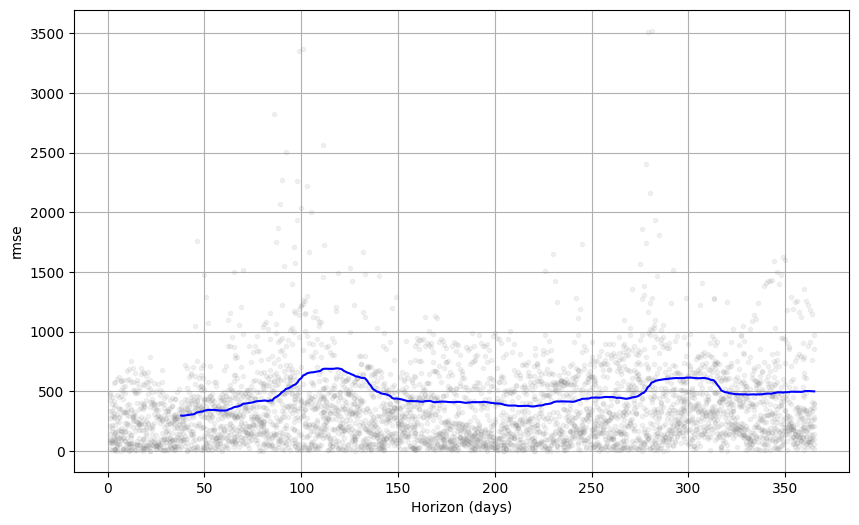

In [19]:
# Compute performance metrics
metrics = performance_metrics(cv_results)

# Display performance metrics
print(metrics)

# Plot a metric over the forecast horizon (e.g., RMSE)
from prophet.plot import plot_cross_validation_metric

fig = plot_cross_validation_metric(cv_results, metric='rmse')
